In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df_combine = pd.read_csv('address_data_combined.csv')
print(df_combine.shape)
print(df_combine.head())
f_txn = len(df_combine[df_combine['FLAG'] == 1])
print('current amount of fraud is now ', f_txn, ' which is ', (f_txn/len(df_combine))*100, ' % of the original dataset')

(14155, 14)
                                      Address  FLAG  Avg min between sent tnx  \
0  0x87d884aaa6ff9e9b6014631b0abae80b53953fb8     1                   5151.68   
1  0xd42393df90d582bd8a5493171f0173e3a017d391     1                   1179.02   
2  0x3025c36d8a9620d3df89e9e9b1acbdfd639a6f37     1                    361.73   
3  0x6309f709faad518fc158af4c14edfa7b06424770     1                      0.00   
4  0x3d020954e30c3d40b7f0c533cf198bc10dd45a49     1                  14280.60   

   Avg min between received tnx  Time Diff between first and last (Mins)  \
0                      15159.08                                 71235.62   
1                       1124.89                                 25126.45   
2                          0.00                                   723.47   
3                          0.00                                     0.00   
4                       1479.86                                 45357.57   

   Unique Received From Addresses  min value

In [4]:
df_combine = df_combine.dropna()
print(df_combine.shape)

(14155, 14)


In [5]:
df_combine.nunique()

Address                                                 14155
FLAG                                                        2
Avg min between sent tnx                                 7780
Avg min between received tnx                             8587
Time Diff between first and last (Mins)                 10729
Unique Received From Addresses                            376
min value received                                       6054
max value received                                       7919
avg val received                                         9406
min val sent                                             6177
avg val sent                                             8695
total transactions (including tnx to create contract      977
total ether received                                     9318
total ether balance                                      8055
dtype: int64

In [6]:
# First performing random forest
print('Random forest can only classify numerical columns, hence further processing needs to be done')
df_combine_forest = df_combine.select_dtypes(include='number')
print(df_combine_forest.shape)

Random forest can only classify numerical columns, hence further processing needs to be done
(14155, 13)


In [7]:
x = df_combine_forest.drop('FLAG',axis=1)
print(x.shape)
y = df_combine_forest['FLAG'] # y_column needs to be 1d
print(y.shape)

(14155, 12)
(14155,)


In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x,y,train_size=0.7,random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9908, 12), (4247, 12), (9908,), (4247,))

In [9]:
TOTAL_TREES = 100
classifier_rf = RandomForestClassifier(random_state=42,n_jobs=-1,n_estimators=TOTAL_TREES)
classifier_rf.fit(X_train,y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [10]:
# Hyperparameter tuning for random forest using gridsearchcv to fit the data

rf = RandomForestClassifier(random_state=42,n_jobs=-1)

params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10,25,30,50,100,200]
}

from sklearn.model_selection import GridSearchCV

In [11]:
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv=4,
                           n_jobs=-1,
                           verbose=1,
                           scoring="f1")

In [12]:
grid_search.fit(X_train,y_train)

Fitting 4 folds for each of 180 candidates, totalling 720 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100, 200],
                         'n_estimators': [10, 25, 30, 50, 100, 200]},
             scoring='f1', verbose=1)

In [13]:
print(grid_search.best_score_)
rf_best = grid_search.best_estimator_
print(rf_best)

0.9152793768496371
RandomForestClassifier(max_depth=20, min_samples_leaf=5, n_estimators=200,
                       n_jobs=-1, random_state=42)


In [14]:
from sklearn.metrics import f1_score, roc_auc_score, recall_score, accuracy_score, precision_score
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=20, min_samples_leaf=5, n_estimators=50, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print('F1 score:', f1_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('ROC-AUC score:', roc_auc_score(y_test, y_pred))


F1 score: 0.9229583975346687
Recall: 0.9145038167938931
Accuracy: 0.9293619025194255
Precision: 0.9315707620528771
ROC-AUC score: 0.9283299101497949


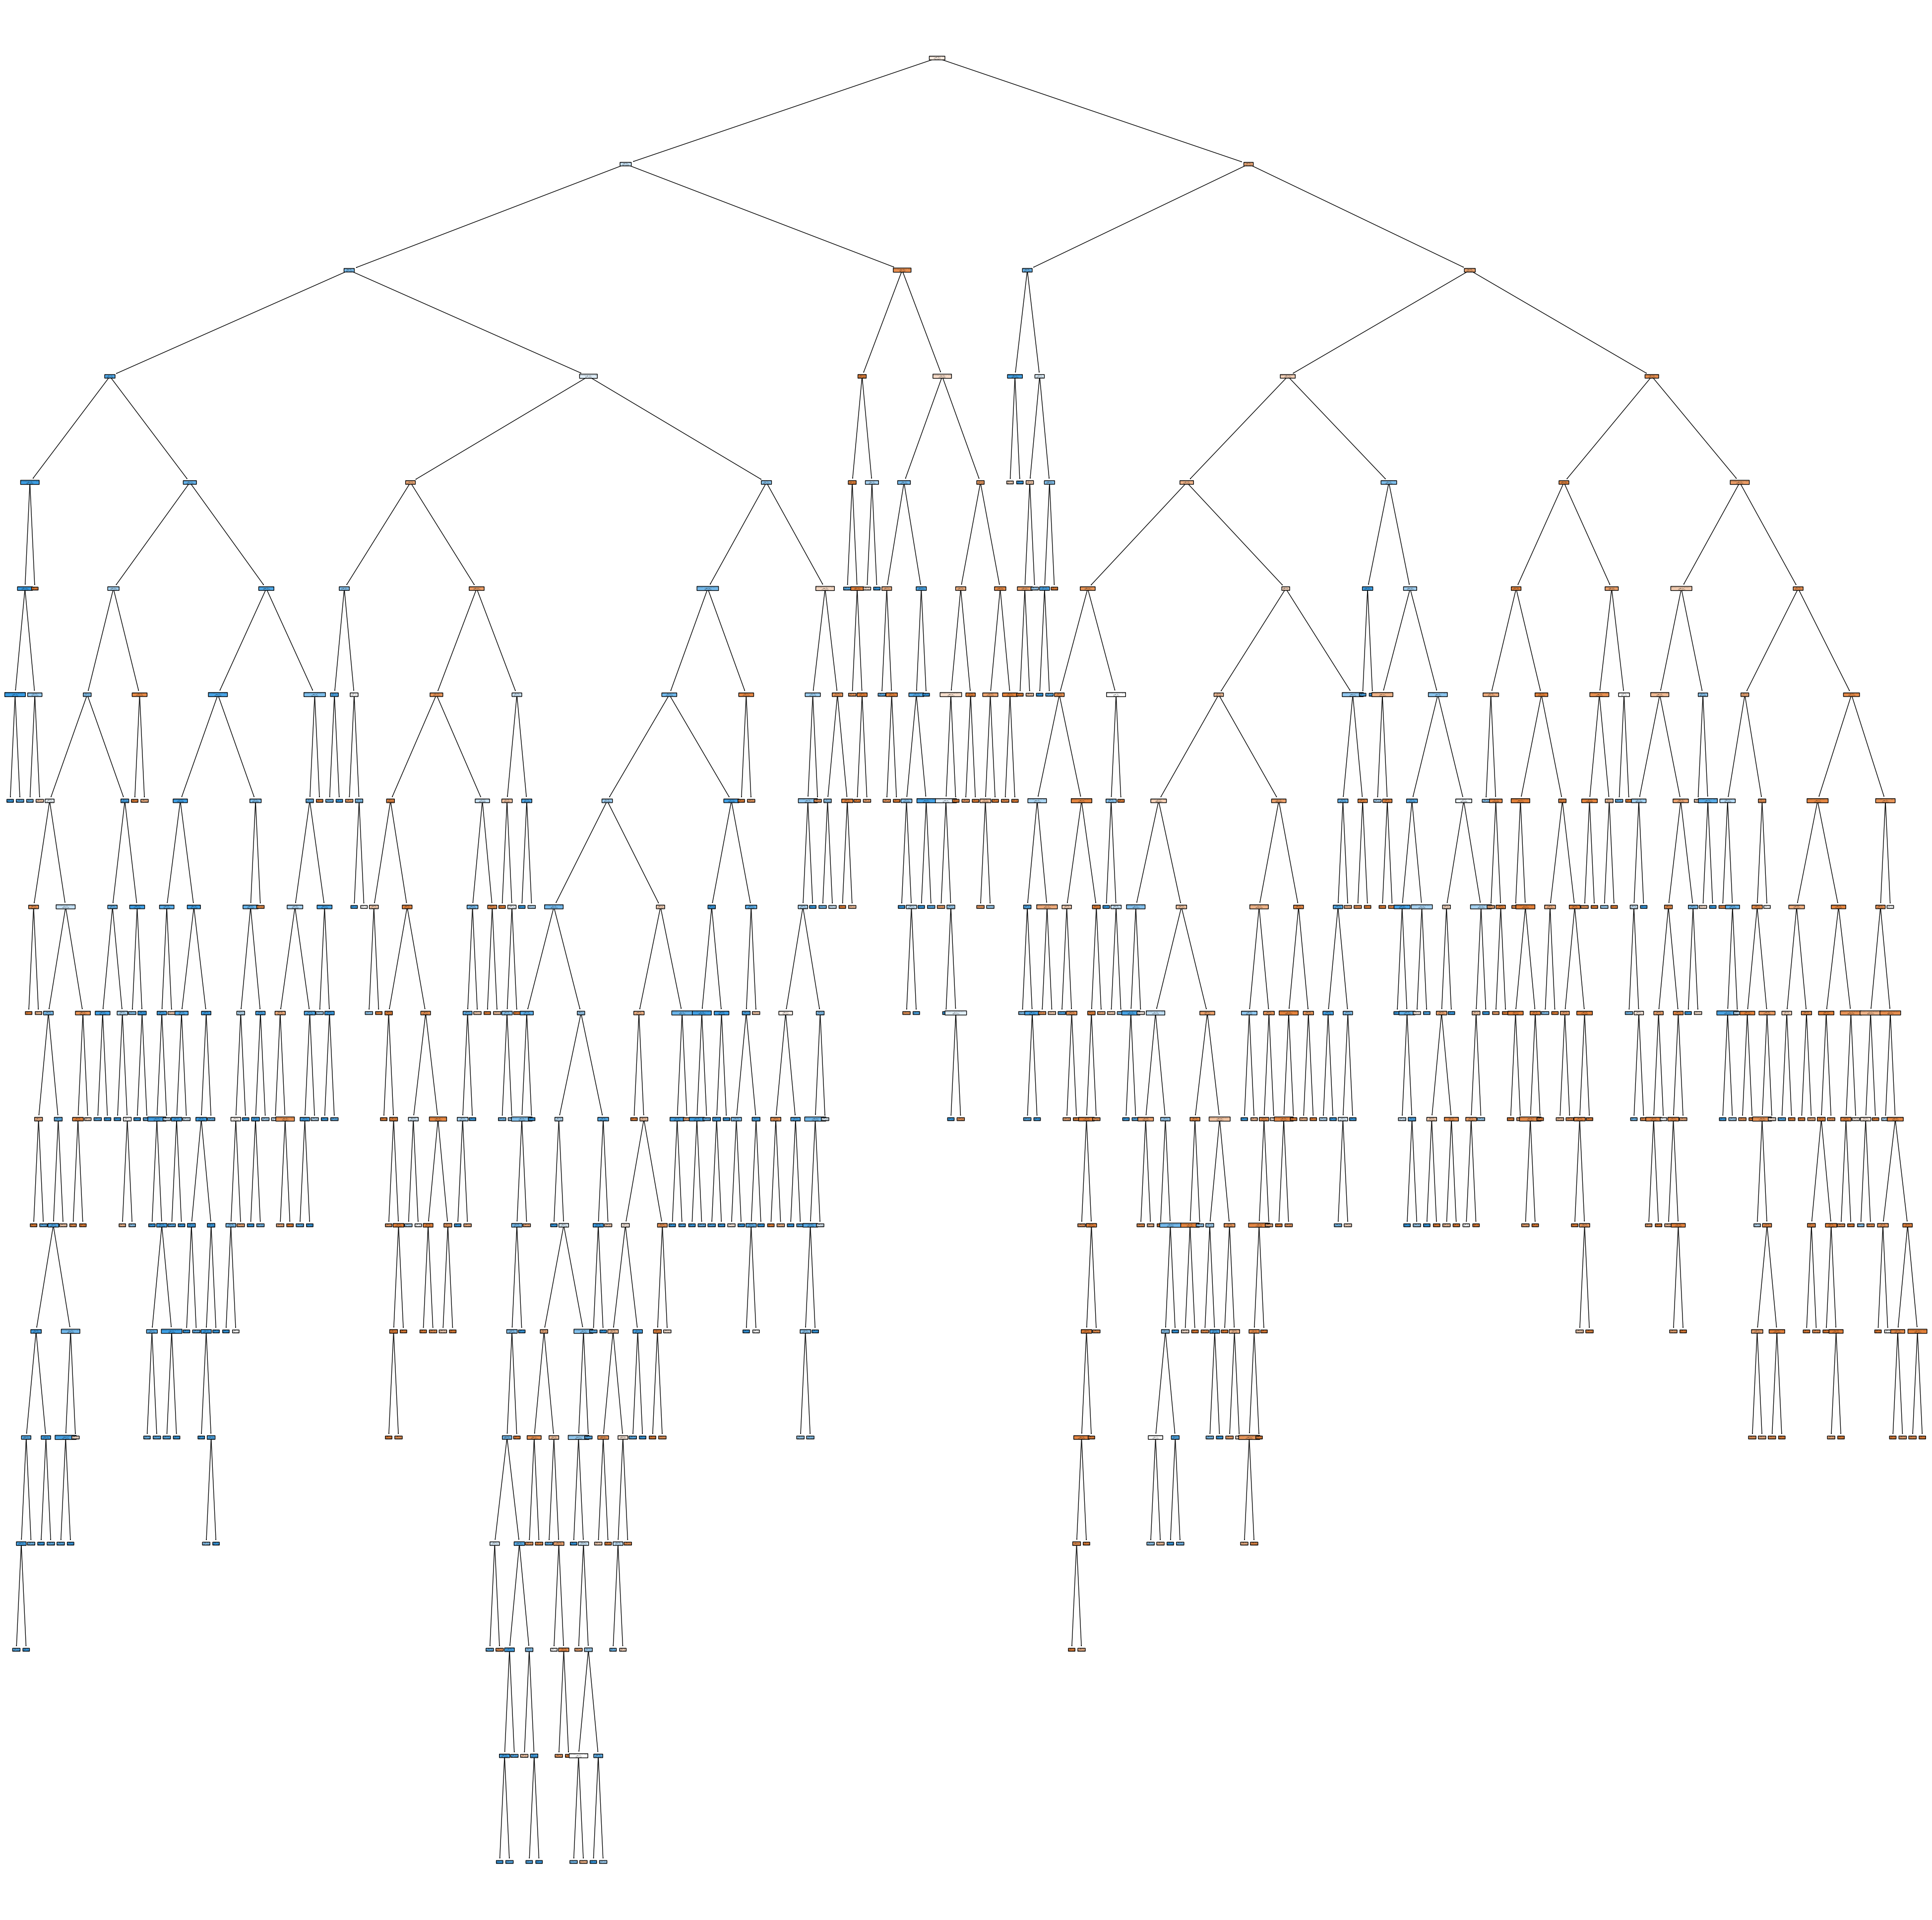

In [15]:
from sklearn.tree import plot_tree
plt.figure(figsize=(50,50))
plot_tree(rf_best.estimators_[5], feature_names = x.columns,class_names=['Fraud', "No Fraud"],filled=True,proportion=True,rounded=True,precision=2)
plt.savefig("tree.eps")

In [16]:
# sorting the date by feature importance
rf_best.feature_importances_

array([0.08691271, 0.09239509, 0.14161212, 0.10961289, 0.0333193 ,
       0.07941098, 0.09644422, 0.03687191, 0.02896612, 0.07321607,
       0.13651761, 0.08472098])

In [17]:
feature_imp_df = pd.DataFrame({
    "Features" : X_train.columns,
    "Importance" : rf_best.feature_importances_
})
feature_imp_df.sort_values(by="Importance",ascending=False)

,Features,Importance
2,Time Diff between first and last (Mins),0.141612
10,total ether received,0.136518
3,Unique Received From Addresses,0.109613
6,avg val received,0.096444
1,Avg min between received tnx,0.092395
0,Avg min between sent tnx,0.086913
11,total ether balance,0.084721
5,max value received,0.079411
9,total transactions (including tnx to create co...,0.073216
7,min val sent,0.036872


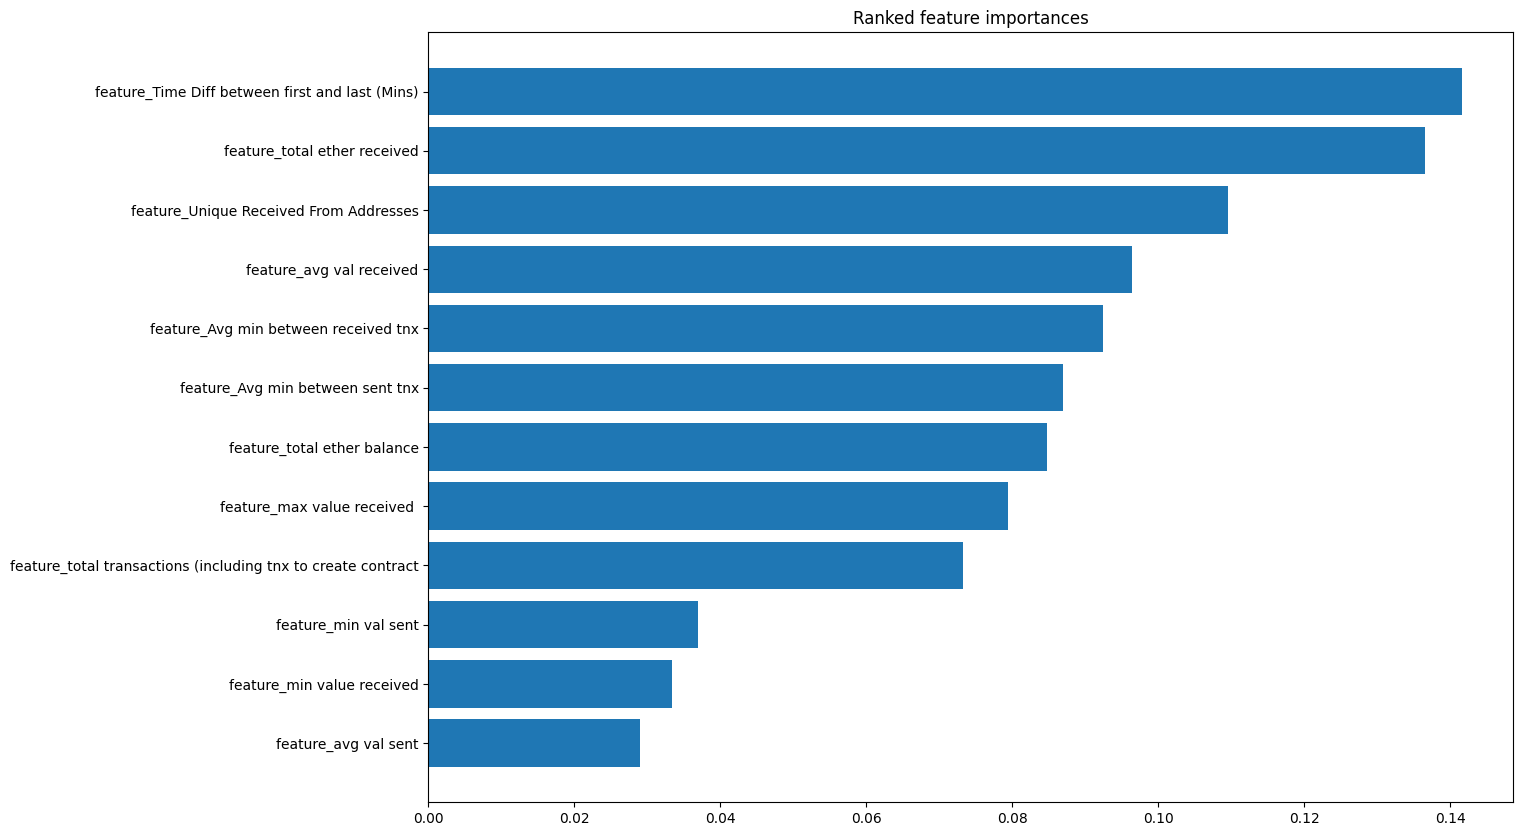

In [18]:
from matplotlib import pyplot as plt
feat_importances = rf_best.feature_importances_
indices = np.argsort(feat_importances)
# plot
columns = np.array(X_train.columns)
fig, ax = plt.subplots(figsize=(14, 10))
plt.title("Ranked feature importances")
plt.barh(range(len(feat_importances)), feat_importances[indices], align="center")
features = ['feature_{}'.format(columns[i]) for i in range(len(columns))]
plt.yticks(range(len(feat_importances)), [features[idx] for idx in indices])
plt.ylim([-1, len(feat_importances)])
plt.show();